# Problem Statement:
Th Goal is to predict the price of flight ticket from the dataset provided from the month of march and June 2019 with various airlines between various cities.

# Importing libraries

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost 
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [129]:
train = pd.read_csv('Data_Train.csv')

In [130]:
test = pd.read_csv('Test_set.csv')

In [131]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)

# Test Set Initial Analysis

In [132]:
df_test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL ? BOM ? COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? MAA ? BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR ? DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


- The test has no target variables.
- Number of rows present in test set is less then train set.
- All the cols has object values.

In [133]:
df_test.shape

(2671, 10)

- Test set has 2671 rows less then train set and 10 cols.
- Target col price is not there.

In [134]:
df_train.shape

(10683, 11)

- train  set has 10683 rows and 11 cols.
- Target col price is present in th train set.

In [135]:
df_test['year'] = pd.DatetimeIndex(df_test['Date_of_Journey']).year

In [136]:
df_test['month'] = pd.DatetimeIndex(df_test['Date_of_Journey']).month

In [137]:
df_test['day'] = pd.DatetimeIndex(df_test['Date_of_Journey']).day

In [138]:
df_test.drop(['Date_of_Journey'],axis=1,inplace=True)

In [139]:
df_test.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,year,month,day
0,Jet Airways,Delhi,Cochin,DEL ? BOM ? COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info,2019,6,6
1,IndiGo,Kolkata,Banglore,CCU ? MAA ? BLR,06:20,10:20,4h,1 stop,No info,2019,12,5
2,Jet Airways,Delhi,Cochin,DEL ? BOM ? COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included,2019,5,21
3,Multiple carriers,Delhi,Cochin,DEL ? BOM ? COK,08:00,21:00,13h,1 stop,No info,2019,5,21
4,Air Asia,Banglore,Delhi,BLR ? DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info,2019,6,24


- the train & test set has one date col "Date_of_Journey" which is converted to seprate year, month & day col.
- After that "Date_of_Journey" is dropped.

In [140]:
df_test.isnull().sum()

Airline            0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
year               0
month              0
day                0
dtype: int64

- Test set has no missing value

In [141]:
objects_df = df_test.select_dtypes(exclude=numerics_var)

-  test set is converted to object dataframe as there is no numneric col

In [142]:
objects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Source           2671 non-null   object
 2   Destination      2671 non-null   object
 3   Route            2671 non-null   object
 4   Dep_Time         2671 non-null   object
 5   Arrival_Time     2671 non-null   object
 6   Duration         2671 non-null   object
 7   Total_Stops      2671 non-null   object
 8   Additional_Info  2671 non-null   object
dtypes: object(9)
memory usage: 187.9+ KB


-  The test set has 9 object cols

In [143]:
# categorical variable encoding
cat_vars_list = objects_df.columns.tolist()
## Label Encoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for i in cat_vars_list :
    df_test[i] = le.fit_transform(df_test[i])

- All the object col is label encoded with test set DataFrame for further analysis.

In [144]:
df_test.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,year,month,day
0,4,2,1,76,138,150,10,0,5,2019,6,6
1,3,3,0,65,31,353,248,0,5,2019,12,5
2,4,2,1,76,156,566,148,0,3,2019,5,21
3,6,2,1,76,48,633,36,0,5,2019,5,21
4,0,0,2,16,198,135,216,4,5,2019,6,24


- The test set is seen with encoded value which will be used to predict the price once model is ready with train set.

# Train data Analysis

In [145]:
df_train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302


- The Train set has target variable-Price.
- Number of rows present in test set is less then train set.
- All the cols has object values.
- Target is continous varibles.

In [147]:
df_train.shape

(10683, 11)

- Train has 10683 rows and 11 cols
- Number of rows is high in train set.

In [149]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


- One Int Col which is Price at index 10.
- Rest all are object variables.

In [151]:
df_train['year'] = pd.DatetimeIndex(df_train['Date_of_Journey']).year

In [152]:
df_train['month'] = pd.DatetimeIndex(df_train['Date_of_Journey']).month

In [153]:
df_train['day'] = pd.DatetimeIndex(df_train['Date_of_Journey']).day

In [154]:
df_train.drop(['Date_of_Journey'],axis=1,inplace=True)

- the train & test set has one date col "Date_of_Journey" which is converted to seprate year, month & day col.
- After that "Date_of_Journey" is dropped.

In [155]:
df_train.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,year,month,day
0,IndiGo,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,2019,3,24
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662,2019,1,5
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,2019,9,6
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218,2019,12,5
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302,2019,1,3


In [156]:
df_train.isnull().sum()

Airline            0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
year               0
month              0
day                0
dtype: int64

- Route & Total_Stops has one missing value each

In [157]:
df_train['Route'].fillna(df_train['Route'].value_counts().idxmax(),inplace=True)

In [158]:
df_train['Total_Stops'].fillna(df_train['Total_Stops'].value_counts().idxmax(),inplace=True)

In [159]:
df_train.isnull().sum()

Airline            0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
year               0
month              0
day                0
dtype: int64

- As the cols is object type missing value is removed by frequency count.

In [160]:
df_train.shape

(10683, 13)

- The number oc col is increased as the date col is separated into year,month & day cols.

In [161]:
numerics_var = ['float64', 'int64']
numeric_df = df_train.select_dtypes(include=numerics_var)
objects_df = df_train.select_dtypes(exclude=numerics_var)

- Train set is divided into object & numeric variables.
- Where all are the object cols except price is the numeric col.

In [162]:
objects_df

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,IndiGo,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info
...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,CCU ? BLR,19:55,22:25,2h 30m,non-stop,No info
10679,Air India,Kolkata,Banglore,CCU ? BLR,20:45,23:20,2h 35m,non-stop,No info
10680,Jet Airways,Banglore,Delhi,BLR ? DEL,08:20,11:20,3h,non-stop,No info
10681,Vistara,Banglore,New Delhi,BLR ? DEL,11:30,14:10,2h 40m,non-stop,No info


In [163]:
objects_df.describe()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
count,10683,10683,10683,10683,10683,10683,10683,10683,10683
unique,12,5,6,128,222,1343,368,5,10
top,Jet Airways,Delhi,Cochin,DEL ? BOM ? COK,18:55,19:00,2h 50m,1 stop,No info
freq,3849,4537,4537,2377,233,423,550,5626,8345


- There are 12 Airlines operator where jetairways freq used is highest.
- The most route trafic is from DEL-BOM_COK which tops the counts.
- The datset shows highest destination count is Cochin.
- The highest duration of travel is 2h50m whose freq count is highest.

In [164]:
# categorical variable encoding
cat_vars_list = objects_df.columns.tolist()
## Label Encoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for i in cat_vars_list :
    df_train[i] = le.fit_transform(df_train[i])

-  Object col of train set is label encoded with train dataframe for further analysis.

In [165]:
df_train.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,year,month,day
0,3,0,5,18,211,233,240,4,8,3897,2019,3,24
1,1,3,0,84,31,906,336,1,8,7662,2019,1,5
2,4,2,1,118,70,413,106,1,8,13882,2019,9,6
3,3,3,0,91,164,1324,311,0,8,6218,2019,12,5
4,3,0,5,29,149,1237,303,0,8,13302,2019,1,3


- train dataframe shows label encoded values.

In [166]:
df_train.isnull().sum()

Airline            0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
year               0
month              0
day                0
dtype: int64

- Missing value is not seen after label encoding and already removed before labelencoder applied to train dataframe.

In [167]:
corr = df_train.corr()
corr

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,year,month,day
Airline,1.000000,-0.013401,0.018479,0.025118,-0.039439,-0.015733,0.027917,0.036064,-0.060802,-0.039520,NaN,-0.007918,0.031218
Source,-0.013401,1.000000,-0.592574,0.403403,0.055191,0.020844,-0.192009,-0.225601,-0.022107,0.015998,NaN,0.063052,0.007560
Destination,0.018479,-0.592574,1.000000,-0.461183,-0.063608,-0.036830,0.022037,0.337883,0.026806,-0.071112,NaN,-0.105039,-0.052076
Route,0.025118,0.403403,-0.461183,1.000000,-0.082051,0.010560,-0.062097,-0.437783,0.035188,0.164118,NaN,0.042204,0.096530
Dep_Time,-0.039439,0.055191,-0.063608,-0.082051,1.000000,-0.023294,0.041619,0.044687,-0.052853,0.002949,NaN,0.027747,-0.003399
Arrival_Time,-0.015733,0.020844,-0.036830,0.010560,-0.023294,1.000000,0.027746,-0.097132,0.017505,0.027377,NaN,-0.002303,0.001485
Duration,0.027917,-0.192009,0.022037,-0.062097,0.041619,0.027746,1.000000,0.175207,0.080151,-0.144270,NaN,-0.038864,0.024767
Total_Stops,0.036064,-0.225601,0.337883,-0.437783,0.044687,-0.097132,0.175207,1.000000,0.164009,-0.571174,NaN,-0.056524,0.043907
Additional_Info,-0.060802,-0.022107,0.026806,0.035188,-0.052853,0.017505,0.080151,0.164009,1.000000,-0.065478,NaN,-0.009098,-0.019456
Price,-0.039520,0.015998,-0.071112,0.164118,0.002949,0.027377,-0.144270,-0.571174,-0.065478,1.000000,NaN,0.010700,-0.165412


-  All the variables is categorical variables.
-  Corr of cat variables is not least important which is not effecting model performance.
-  Only target col-Price  is continous
-  Corr is less significant in cat variables.

<AxesSubplot:>

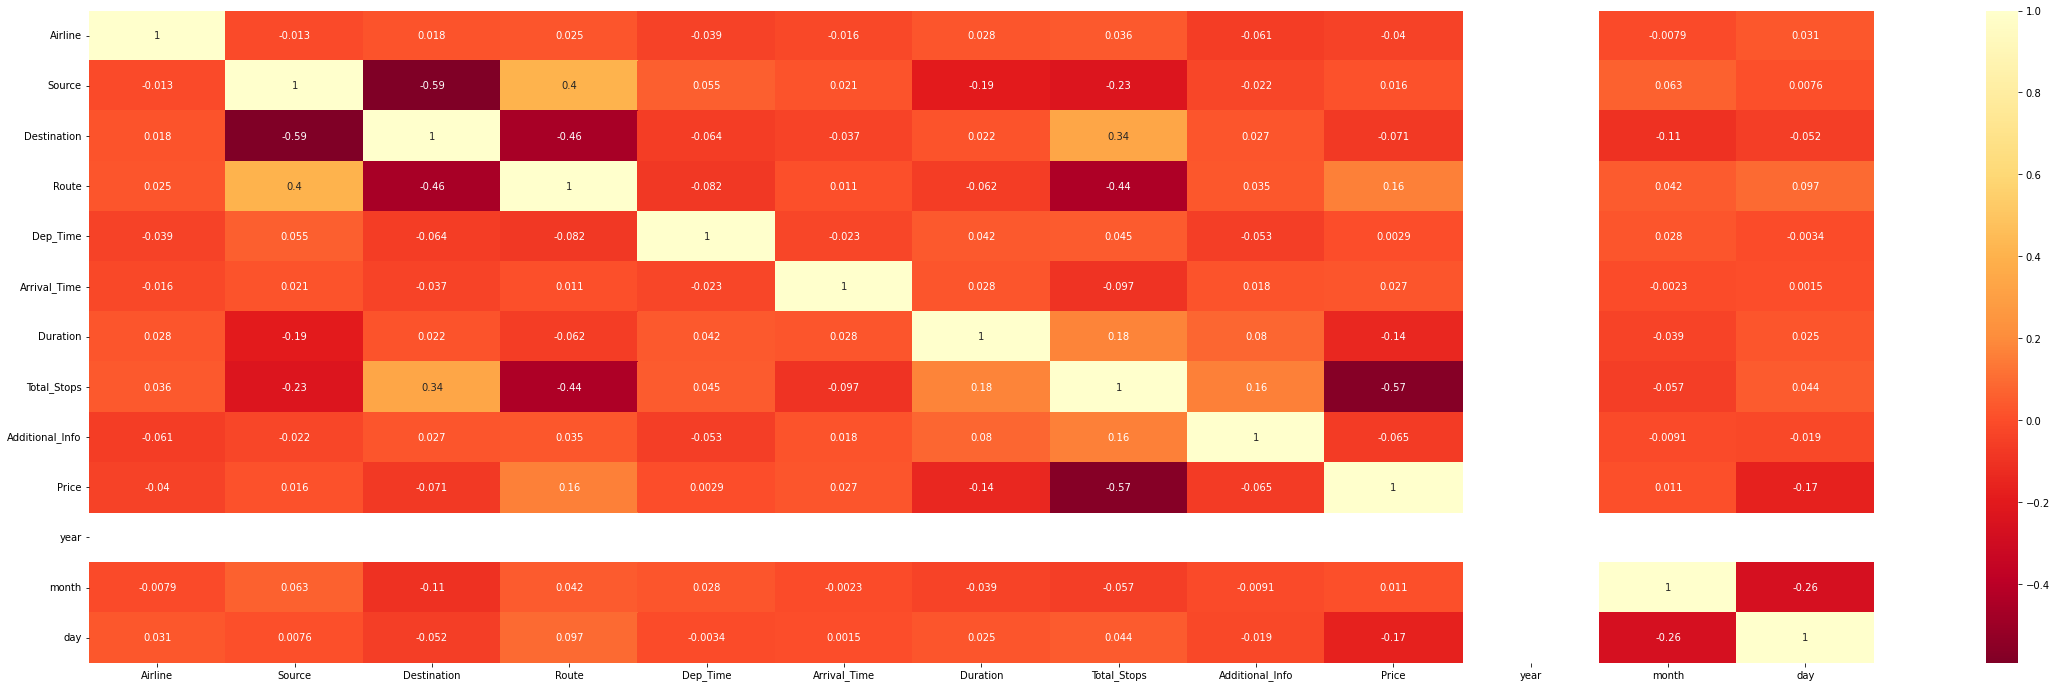

In [168]:
plt.figure(figsize=(40,12))
sns.heatmap(corr,cmap='YlOrRd_r', annot=True)

-  All the variables is categorical variables.
-  Corr of cat variables is not least important which is not effecting model performance.
-  Only target col-Price  is continous
-  Corr is less significant in cat variables.

In [169]:
df_train['year'].head()

0    2019
1    2019
2    2019
3    2019
4    2019
Name: year, dtype: int64

-  The blank row in above plot is because year is same in the dataset which is 2019 as shown above.

# Skewness

In [170]:
df_train.skew()

Airline            0.731095
Source            -0.424054
Destination        1.244169
Route             -0.502066
Dep_Time           0.195055
Arrival_Time      -0.606530
Duration          -0.213427
Total_Stops        0.631681
Additional_Info   -1.779838
Price              1.812552
year               0.000000
month              0.629540
day                0.367373
dtype: float64

In [ ]:
- Only Target col is continous which is Right skewed data.

<AxesSubplot:xlabel='Price', ylabel='Density'>

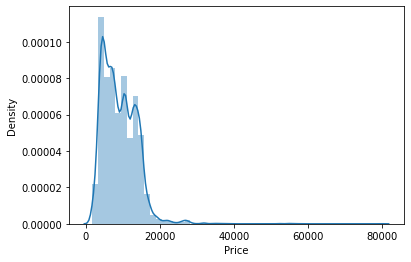

In [171]:
sns.distplot(df_train['Price'])

- Only Target col is continous which is Right skewed data.

Airline            0.731095
Source            -0.424054
Destination        1.244169
Route             -0.502066
Dep_Time           0.195055
Arrival_Time      -0.606530
Duration          -0.213427
Total_Stops        0.631681
Additional_Info   -1.779838
Price              0.431747
year               0.000000
month              0.629540
day                0.367373
dtype: float64

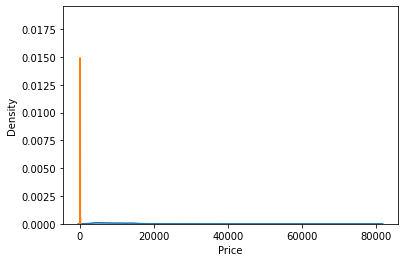

In [172]:
import numpy as np
sns.distplot(df_train['Price'])
df_train['Price']=np.sqrt(df_train['Price'])
sns.distplot(df_train['Price'])
df_train.skew()

-  Skewness is reduced to normal range with sqrt method where the value falls between +0.5  to -0.5 range.

<AxesSubplot:>

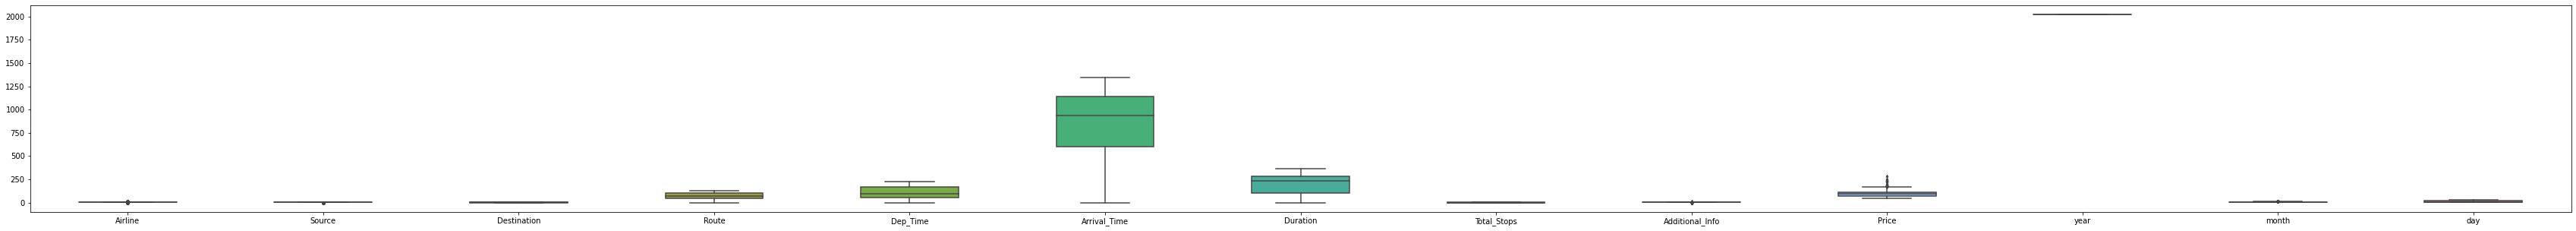

In [173]:
fig, ax =plt.subplots(figsize=(60,5))
sns.boxplot(data=df_train, width = 0.5,ax=ax, fliersize=3)

- Train set has no outliers

In [174]:
x=df_train.drop("Price",axis=1)
y=df_train["Price"]

In [175]:
x.shape

(10683, 12)

In [176]:
y.shape

(10683,)

In [177]:
from sklearn.preprocessing import StandardScaler
scaling = StandardScaler()
x=scaling.fit_transform(x)
x

array([[-0.41067545, -1.65844074,  2.41666505, ...,  0.        ,
        -0.84850298,  1.28563248],
       [-1.26099927,  0.89005213, -0.97382594, ...,  0.        ,
        -1.5179928 , -0.8726517 ],
       [ 0.01448647,  0.04055451, -0.29572775, ...,  0.        ,
         1.15996647, -0.7590578 ],
       ...,
       [ 0.01448647, -1.65844074,  0.38237045, ...,  0.        ,
        -0.51375808,  1.62641419],
       [ 2.56545795, -1.65844074,  2.41666505, ...,  0.        ,
        -1.5179928 , -1.09983951],
       [-1.26099927,  0.04055451, -0.29572775, ...,  0.        ,
         1.15996647, -0.8726517 ]])

# Model building & Predicting on Train data.

- As the all object col is label encoded where the values are not in same range so the sclaing is applied on independent variables x

In [178]:
for i in range(200):
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.33, random_state=i)
    
    DTR = DecisionTreeRegressor()
    DTR.fit(x_train, y_train)
    pred=DTR.predict(x_test)
    MAE= mean_absolute_error(y_test,pred)
    print(MAE, "at random_state", i)

3.6483976766023742 at random_state 0
3.610508215096741 at random_state 1
3.6680974699580764 at random_state 2
3.944017587696681 at random_state 3
3.6393729795756924 at random_state 4
3.9273778101706087 at random_state 5
3.819878313881572 at random_state 6
3.561123880087214 at random_state 7
3.6578457534389477 at random_state 8
3.5562891389624918 at random_state 9
3.620994844872034 at random_state 10
3.795149132179604 at random_state 11
3.8318299296035736 at random_state 12
3.5152582589148036 at random_state 13
3.6237786052963328 at random_state 14
3.5947030479623048 at random_state 15
3.8013432346222076 at random_state 16
3.6153148280350162 at random_state 17
3.6516798002243656 at random_state 18
3.51193108765207 at random_state 19
3.8767560734704434 at random_state 20
3.543123371651809 at random_state 21
3.5164748961523777 at random_state 22
3.8181230728074715 at random_state 23
3.697338513081368 at random_state 24
3.7472492758097626 at random_state 25
3.733924848394653 at random_stat

In [179]:
leastMAE=0
maxRS=0
for i in range(1,200):
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30, random_state = i)
    DTR = DecisionTreeRegressor()
    DTR.fit(x_train, y_train)
    pred = DTR.predict(x_test)
    MAE= mean_absolute_error(y_test,pred)
    if MAE>leastMAE:
        leastMAE=MAE
        maxRS=i
print("Least MAE ", leastMAE," on Random_state ",maxRS)

Least MAE  4.025759679548609  on Random_state  56


In [180]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30, random_state = 56)

In [181]:
lm = LinearRegression() # linear regression instance
lm.fit(x_train,y_train) # applying linear regression on training set to learn the linear relationship.
pred=lm.predict(x_test) # Applying linear Reg on test data
print('Mean Absolute error: ',mean_absolute_error(y_test,pred)) # Calculating MAE error between actual actual y value & prdicted y value
print('Mean Squared error: ',mean_squared_error(y_test,pred))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,pred)))
print(r2_score(y_test,pred))
lm.score(x_train,y_train) # how well the model learned

Mean Absolute error:  13.92784208769995
Mean Squared error:  316.1133303493935
Root Mean Squared Error: 17.779576213998844
0.4463431813322112


0.4486919480129493

In [182]:
DTR = DecisionTreeRegressor()
DTR.fit(x_train, y_train)
pred = DTR.predict(x_test)
print('Mean Absolute error: ',mean_absolute_error(y_test,pred)) # Calculating MAE error between actual actual y value & prdicted y value
print('Mean Squared error: ',mean_squared_error(y_test,pred))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,pred)))
print(r2_score(y_test,pred))
DTR.score(x_train,y_train) # how well the model learned

Mean Absolute error:  4.002322806999107
Mean Squared error:  87.29261213269122
Root Mean Squared Error: 9.343051542868166
0.8471113196233492


0.996950995743365

In [183]:
RFR = RandomForestRegressor()  # Random Forest regressor instance
RFR.fit(x_train, y_train) # applying Random Forest regressor on training set to learn relationship.
pred = RFR.predict(x_test) # Applying linear Reg on test data
print('Mean Absolute error: ',mean_absolute_error(y_test,pred)) # Calculating MAE error between actual actual y value & prdicted y value
print('Mean Squared error: ',mean_squared_error(y_test,pred))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,pred)))
print(r2_score(y_test,pred))
RFR.score(x_train,y_train) # how well the model learned

Mean Absolute error:  3.4782416026605887
Mean Squared error:  53.21969550140127
Root Mean Squared Error: 7.295183034126098
0.9067883430628924


0.9875528847839621

In [184]:
SV = SVR() # Support Vector Reg Instance
SV.fit(x_train, y_train) # applying Support Vector Reg on training set to learn  relationship.
pred = SV.predict(x_test) # Applying Support Vector Reg on test data
print('Mean Absolute error: ',mean_absolute_error(y_test,pred)) # Calculating MAE error between actual actual y value & prdicted y value
print('Mean Squared error: ',mean_squared_error(y_test,pred))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,pred)))
print(r2_score(y_test,pred))
SV.score(x_train,y_train)# how well the model learned

Mean Absolute error:  10.705480090625487
Mean Squared error:  239.11541164594078
Root Mean Squared Error: 15.463357062615504
0.581201216791444


0.5920240126816099

In [185]:
XGBR = XGBRegressor() # XGBR Instance
XGBR.fit(x_train,y_train) # applying XGBR on training set to learn  relationship.
pred = XGBR.predict(x_test) # Applying XGBR on test data
print('Mean Absolute error: ', mean_absolute_error(y_test,pred))# Calculating MAE error between actual actual y value & prdicted y value
print('Mean Squared error: ',mean_squared_error(y_test,pred))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,pred)))
print(r2_score(y_test,pred))
XGBR.score(x_train,y_train) # how well the model learned     

Mean Absolute error:  3.819408311295202
Mean Squared error:  44.07873728131673
Root Mean Squared Error: 6.639181973806466
0.9227982779875392


0.9770115166178938

# K-Fold Cross validation

In [186]:
from sklearn.model_selection import cross_val_score  # Obs : Importing cross val score
from sklearn.model_selection import KFold  # Obs : Imporing Kfold CV

In [187]:
cross_validation=KFold(5, shuffle =True)
# Obs : Creating CV Object with shuffle = true to avoid -ve CV Values as o/p

In [188]:
print(cross_val_score(lm,x,y,cv=cross_validation).mean()) # Obs : Linear Regression CV o/p

0.4469232691127091


In [189]:
print(cross_val_score(DTR,x,y,cv=cross_validation).mean()) # Obs :  DTR Regression CV o/p

0.8876100863087004


In [190]:
print(cross_val_score(RFR,x,y,cv=cross_validation).mean()) # Obs : Random Forest Regressor CV o/p

0.9235533039036244


In [191]:
print(cross_val_score(SV,x,y,cv=cross_validation).mean()) # Obs : Support Vector CV o/p

0.5914676486341357


In [192]:
print(cross_val_score(XGBR,x,y,cv=cross_validation).mean()) # Obs :  XGBoost Regressor CV o/p

0.9310874458969065


# Best Model : 
XGBR as the best model as it MSE is very less as well as CV score & R2 score is also high.

In [193]:
from sklearn.model_selection import GridSearchCV # Obs : importing GridSearchCV

In [194]:
import numpy as np
parameter = {'eta': [0.01,0.02],
             'max_depth': np.arange(2,10),
             'subsample': [0,1],
             'colsample_bytree': [0,1],
             'n_estimators': [10]}

In [195]:
GCV=GridSearchCV(XGBRegressor(),parameter,cv=cross_validation)
# Creating Grid Search CV Object and Applying GridSearch on best Model - XGBR

In [196]:
GCV.fit(x_train,y_train) # Applying XGBR-Gridsearch to training set with parameters

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                  

In [197]:
GCV.best_params_ # Giving the Best Gridserach Parameters

{'colsample_bytree': 1,
 'eta': 0.02,
 'max_depth': 9,
 'n_estimators': 10,
 'subsample': 1}

In [200]:
Final_mod = XGBRegressor(colsample_bytree = 1, eta= 0.02, max_depth = 9,n_estimators = 10, subsample = 1)
Final_mod.fit(x_train, y_train)
pred = Final_mod.predict(x_test)
print('Mean Absolute error: ',mean_absolute_error(y_test,pred))
print('Mean Squared error: ',mean_squared_error(y_test,pred))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,pred)))
print(r2_score(y_test,pred))
XGBR.score(x_train,y_train) # how well the model learned

# Applying Best XGBR hyperparameter to the model and predicting MAE

Mean Absolute error:  75.6578339536939
Mean Squared error:  6144.90312371658
Root Mean Squared Error: 78.38943247477035
-9.762493029757191


0.9770115166178938

# Model building & Predicting on Test data

In [201]:
z = df_test

In [202]:
z

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,year,month,day
0,4,2,1,76,138,150,10,0,5,2019,6,6
1,3,3,0,65,31,353,248,0,5,2019,12,5
2,4,2,1,76,156,566,148,0,3,2019,5,21
3,6,2,1,76,48,633,36,0,5,2019,5,21
4,0,0,2,16,198,135,216,4,5,2019,6,24
...,...,...,...,...,...,...,...,...,...,...,...,...
2666,1,3,0,51,170,617,150,0,5,2019,6,6
2667,3,3,0,43,106,507,213,4,5,2019,3,27
2668,4,2,1,76,183,151,278,0,5,2019,6,3
2669,1,2,1,76,11,577,60,0,5,2019,6,3


In [203]:
z.shape

(2671, 12)

In [204]:
y.shape

(10683,)

In [205]:
y

0         62.425956
1         87.532851
2        117.821899
3         78.854296
4        115.334297
            ...    
10678     64.085880
10679     64.381674
10680     85.023526
10681    112.463327
10682    108.411254
Name: Price, Length: 10683, dtype: float64

In [208]:
y.drop(y.index[2671:10682], inplace = True)

In [209]:
y

0        62.425956
1        87.532851
2       117.821899
3        78.854296
4       115.334297
           ...    
2666    115.926701
2667     69.310894
2668    107.898100
2669     58.472216
2670     78.121700
Name: Price, Length: 2671, dtype: float64

In [210]:
z.shape

(2671, 12)

In [211]:
y.shape

(2671,)

In [212]:
z

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,year,month,day
0,4,2,1,76,138,150,10,0,5,2019,6,6
1,3,3,0,65,31,353,248,0,5,2019,12,5
2,4,2,1,76,156,566,148,0,3,2019,5,21
3,6,2,1,76,48,633,36,0,5,2019,5,21
4,0,0,2,16,198,135,216,4,5,2019,6,24
...,...,...,...,...,...,...,...,...,...,...,...,...
2666,1,3,0,51,170,617,150,0,5,2019,6,6
2667,3,3,0,43,106,507,213,4,5,2019,3,27
2668,4,2,1,76,183,151,278,0,5,2019,6,3
2669,1,2,1,76,11,577,60,0,5,2019,6,3


In [213]:
y

0        62.425956
1        87.532851
2       117.821899
3        78.854296
4       115.334297
           ...    
2666    115.926701
2667     69.310894
2668    107.898100
2669     58.472216
2670     78.121700
Name: Price, Length: 2671, dtype: float64

-  The number of rows in target y is dropped to make it equal to z which is test set dataframe for model building.
-  All the above command is used to make number of rows of target equal to test set z.

In [218]:
for i in range(200):
    z_train, z_test, y_train, y_test = train_test_split(z,y, test_size=0.33, random_state=i)
    
    DTR = DecisionTreeRegressor()
    DTR.fit(z_train, y_train)
    pred=DTR.predict(z_test)
    MAE= mean_absolute_error(y_test,pred)
    print(MAE, "at random_state", i)

27.22518554501455 at random_state 0
28.142750046658662 at random_state 1
29.09334739120043 at random_state 2
27.555019789036407 at random_state 3
27.279039673965922 at random_state 4
26.126246117416887 at random_state 5
27.821360611846774 at random_state 6
27.959654331440717 at random_state 7
27.05609663139678 at random_state 8
28.409763248169966 at random_state 9
28.09144775239508 at random_state 10
27.58028582572082 at random_state 11
27.308448408421032 at random_state 12
27.99406808495589 at random_state 13
27.454864633646455 at random_state 14
27.168309809842263 at random_state 15
27.755889364729494 at random_state 16
26.71602608309779 at random_state 17
26.519987304095288 at random_state 18
26.55346340466992 at random_state 19
27.30003525573808 at random_state 20
26.152988451833757 at random_state 21
28.124348568511365 at random_state 22
28.00464093325278 at random_state 23
26.534211429483875 at random_state 24
27.876454671430945 at random_state 25
28.03322715261708 at random_stat

In [219]:
leastMAE=0
mazRS=0
for i in range(1,200):
    z_train, z_test, y_train, y_test = train_test_split(z,y,test_size=0.30, random_state = i)
    DTR = DecisionTreeRegressor()
    DTR.fit(z_train, y_train)
    pred = DTR.predict(z_test)
    MAE= mean_absolute_error(y_test,pred)
    if MAE>leastMAE:
        leastMAE=MAE
        mazRS=i
print("Least MAE ", leastMAE," on Random_state ",mazRS)

Least MAE  29.120991284359437  on Random_state  33


In [220]:
z_train, z_test, y_train, y_test = train_test_split(z,y,test_size=0.30, random_state = 33)

In [221]:
lm = LinearRegression() # linear regression instance
lm.fit(z_train,y_train) # applying linear regression on training set to learn the linear relationship.
pred=lm.predict(z_test) # Applying linear Reg on test data
print('Mean Absolute error: ',mean_absolute_error(y_test,pred)) # Calculating MAE error between actual actual y value & prdicted y value
print('Mean Squared error: ',mean_squared_error(y_test,pred))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,pred)))
print(r2_score(y_test,pred))
lm.score(z_train,y_train) # how well the model learned


Mean Absolute error:  20.295971587199865
Mean Squared error:  593.2219337434169
Root Mean Squared Error: 24.356147760748556
-0.003827334970593066


0.004730670323555897

In [222]:
DTR = DecisionTreeRegressor()
DTR.fit(z_train, y_train)
pred = DTR.predict(z_test)
print('Mean Absolute error: ',mean_absolute_error(y_test,pred)) # Calculating MAE error between actual actual y value & prdicted y value
print('Mean Squared error: ',mean_squared_error(y_test,pred))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,pred)))
print(r2_score(y_test,pred))
DTR.score(z_train,y_train) # how well the model learned

Mean Absolute error:  28.53150943510139
Mean Squared error:  1279.1442324873653
Root Mean Squared Error: 35.76512592578649
-1.1645186614023206


0.9922079631516194

In [223]:
RFR = RandomForestRegressor()  # Random Forest regressor instance
RFR.fit(z_train, y_train) # applying Random Forest regressor on training set to learn relationship.
pred = RFR.predict(z_test) # Applying linear Reg on test data
print('Mean Absolute error: ',mean_absolute_error(y_test,pred)) # Calculating MAE error between actual actual y value & prdicted y value
print('Mean Squared error: ',mean_squared_error(y_test,pred))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,pred)))
print(r2_score(y_test,pred))
RFR.score(z_train,y_train) # how well the model learned

Mean Absolute error:  21.88249565778635
Mean Squared error:  698.906736431095
Root Mean Squared Error: 26.436844297894087
-0.18266309237323708


0.8289214949276555

In [224]:
SV = SVR() # Support Vector Reg Instance
SV.fit(z_train, y_train) # applying Support Vector Reg on training set to learn  relationship.
pred = SV.predict(z_test) # Applying Support Vector Reg on test data
print('Mean Absolute error: ',mean_absolute_error(y_test,pred)) # Calculating MAE error between actual actual y value & prdicted y value
print('Mean Squared error: ',mean_squared_error(y_test,pred))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,pred)))
print(r2_score(y_test,pred))
SV.score(z_train,y_train)# how well the model learned


Mean Absolute error:  20.26175833022307
Mean Squared error:  592.5136628051096
Root Mean Squared Error: 24.34160353808084
-0.002628826136046758


-0.0009237536649222555

In [225]:
XGBR = XGBRegressor() # zGBR Instance
XGBR.fit(z_train,y_train) # applying zGBR on training set to learn  relationship.
pred = XGBR.predict(z_test) # Applying zGBR on test data
print('Mean Absolute error: ', mean_absolute_error(y_test,pred))# Calculating MAE error between actual actual y value & prdicted y value
print('Mean Squared error: ',mean_squared_error(y_test,pred))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,pred)))
print(r2_score(y_test,pred))
XGBR.score(z_train,y_train) # how well the model learned   


Mean Absolute error:  22.814257389320417
Mean Squared error:  799.340507620727
Root Mean Squared Error: 28.272610555460332
-0.3526132562826194


0.8174868759605812

# K-fold Cross Validation

In [226]:
print(cross_val_score(lm,z,y,cv=cross_validation).mean()) # Obs : Linear Regression CV o/p

-0.004432440783226221


In [227]:
print(cross_val_score(DTR,z,y,cv=cross_validation).mean()) # Obs :  DTR Regression CV o/p


-1.1743151790171575


In [228]:
print(cross_val_score(RFR,z,y,cv=cross_validation).mean()) # Obs : Random Forest Regressor CV o/p

-0.16407407567402302


In [229]:
print(cross_val_score(SV,z,y,cv=cross_validation).mean()) # Obs : Support Vector CV o/p


-0.008501095694633554


In [230]:
print(cross_val_score(XGBR,z,y,cv=cross_validation).mean()) # Obs :  zGBoost Regressor CV o/p

-0.35617098781013967


# Best Model:

I have selected RFR as the best model as it has high CV score and least MSE & MAE. The cv score is negative as  all cols in independenet variable is object type.
So, the data is not linear and spreaded so we get -ve cv score & r2 score.

In [231]:
import numpy as np
parameter = {'max_depth': np.arange(2,8),
             'max_features': ['log2','sqrt','auto'],
             'min_samples_leaf': [1,2],
             'n_estimators': [10]}

In [232]:
GCV=GridSearchCV(RandomForestRegressor(),parameter,cv=cross_validation)
# Creating Grid Search CV Object and Applying GridSearch on best Model - RFR

In [233]:
GCV.fit(z_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7]),
                         'max_features': ['log2', 'sqrt', 'auto'],
                         'min_samples_leaf': [1, 2], 'n_estimators': [10]})

In [234]:
GCV.best_params_ # Giving the Best Gridserach Parameters

{'max_depth': 3,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'n_estimators': 10}

In [235]:
Final_mod = RandomForestRegressor(max_depth = 3, max_features = 'log2', min_samples_leaf = 2,n_estimators= 10)
Final_mod.fit(z_train, y_train)
pred = Final_mod.predict(z_test)
print('Mean Absolute error: ',mean_absolute_error(y_test,pred)) # Calculating MAE error between actual actual y value & prdicted y value
print('Mean Squared error: ',mean_squared_error(y_test,pred))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,pred)))
print(r2_score(y_test,pred))
RFR.score(z_train,y_train) # how well the model learned

Mean Absolute error:  20.289968299548224
Mean Squared error:  593.8584378930713
Root Mean Squared Error: 24.369210859054736
-0.0049044028062568135


0.8289214949276555

In [236]:
import joblib
joblib.dump(Final_mod,"FinalModel.pkl")

['FinalModel.pkl']